# Analyse des clients du site d'e-commerce Olist

In [1]:
# Importation des librairies nécessaires
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
import datetime
from function_utils import haversine_vectorize

In [2]:
sns.set_palette("Pastel2")

## 1) Création d'une segmentation RFM

### Information clients

In [3]:
# Importation des données clients
df_customers = pd.read_csv("datasets/olist_customers_dataset.csv")
df_geo = pd.read_csv("datasets/olist_geolocation_dataset.csv")

In [4]:
# Ajout des données de géolocalisation pour chaque client
df_customers = pd.merge(df_geo, df_customers,
                        right_on=["customer_zip_code_prefix", "customer_city", "customer_state"], 
                        left_on=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], how="right")
df_customers.drop(["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], axis=1, inplace=True)
df_customers = df_customers[['customer_id', "customer_unique_id", "customer_city", "geolocation_lat", "geolocation_lng"]]
df_customers.columns = ["customer_id", "customer_unique_id", "customer_city", "customer_latitude", "customer_longitude"]
df_customers.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866
1,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.497396,-47.399241
2,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.510459,-47.399553
3,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.480940,-47.394161
4,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.515413,-47.398194


In [5]:
print("Nombre d'id unique:", df_customers["customer_unique_id"].nunique())

Nombre d'id unique: 96096


In [6]:
print("Nombre d'id clients:", df_customers["customer_id"].nunique())

Nombre d'id clients: 99441


On remarque un écart important entre les identifiants clients et les identifiants uniques. On va donc supprimer les doublons sur ces deux colonnes.

In [7]:
# Suppression des doublons d'identifiant clients
df_customers.drop_duplicates(subset="customer_id", inplace=True)
df_customers.drop_duplicates(subset="customer_unique_id", inplace=True)

In [8]:
df_customers.shape

(96096, 5)

### Information sur les commandes

In [9]:
# Importation des informations sur les commandes
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv")
df_orders.shape

(99441, 8)

In [10]:
# Association entre commande et clients pour calculer la récence et la fréquence d'achat
df = pd.merge(df_customers, df_orders, left_on="customer_id", right_on="customer_id", how="left")
df.drop_duplicates(subset="customer_id", inplace=True)
df.shape

(96096, 12)

In [11]:
# Importation des informations sur le paiement des commandes
df_orders_payments = pd.read_csv("datasets/olist_order_payments_dataset.csv")
df_orders_payments.shape

(103886, 5)

In [12]:
# Association entre commande et paiements pour calculer la valeur monnaitaire d'un client
df = pd.merge(df, df_orders_payments, left_on="order_id", right_on="order_id", how="right")
df.shape

(103886, 16)

In [13]:
df.head()

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,0a8556ac6be836b46b3e89920d59291c,708ab75d2a007f0564aedd11139c7708,teofilo otoni,-17.851690,-41.493610,b81ef226f3fe1789b1e8b2acac839d17,delivered,2018-04-25 22:01:49,2018-04-25 22:15:09,2018-05-02 15:20:00,2018-05-09 17:36:51,2018-05-22 00:00:00,1,credit_card,8,99.33
1,f2c7fc58a9de810828715166c672f10a,a8b9d3a27068454b1c98cc67d4e31e6f,sao paulo,-23.470015,-46.634846,a9810da82917af2d9aefd1278f1dcfa0,delivered,2018-06-26 11:01:38,2018-06-26 11:18:58,2018-06-28 14:18:00,2018-06-29 20:32:09,2018-07-16 00:00:00,1,credit_card,1,24.39
2,25b14b69de0b6e184ae6fe2755e478f9,6f70c0b2f7552832ba46eb57b1c5651e,sao paulo,-23.454897,-46.656832,25e8ea4e93396b6fa0d3dd708e76c1bd,delivered,2017-12-12 11:19:55,2017-12-14 09:52:34,2017-12-15 20:13:22,2017-12-18 17:24:41,2018-01-04 00:00:00,1,credit_card,1,65.71
3,7a5d8efaaa1081f800628c30d2b0728f,87695ed086ebd36f20404c82d20fca87,juiz de fora,-21.750376,-43.342449,ba78997921bbcdc1373bb41e913ab953,delivered,2017-12-06 12:04:06,2017-12-06 12:13:20,2017-12-07 20:28:28,2017-12-21 01:35:51,2018-01-04 00:00:00,1,credit_card,8,107.78
4,15fd6fb8f8312dbb4674e4518d6fa3b3,4291db0da71914754618cd789aebcd56,conchas,-23.015379,-48.008990,42fdf880ba16b47b59251dd489d4441a,delivered,2018-05-21 13:59:17,2018-05-21 16:14:41,2018-05-22 11:46:00,2018-06-01 21:44:53,2018-06-13 00:00:00,1,credit_card,2,128.45


Pour calculer la récence, on va transformer les éléments en lien avec les dates en format datetime. Ensuite, on va calculer le nombre de jours entre le dernier client à avoir acheté +1 que l'on va soustraire à la dernière date d'achat de chaque client.

In [14]:
# Transformation des timestamps en format datetime
time = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols], format="%Y-%m-%d", errors="ignore")

In [15]:
snapshot_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)

In [16]:
rfm_custom = df.groupby("customer_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "mean"
})

In [17]:
rfm_custom.columns = ["Recency", "Frequency", "MonetaryValue"]
data = rfm_custom.copy().reset_index()

In [18]:
data.head()

,customer_id,Recency,Frequency,MonetaryValue
0,00012a2ce6f8dcda20d059ce98491703,338,1,114.74
1,000161a058600d5901f007fab4c27140,459,1,67.41
2,0001fd6190edaaf884bcaf3d49edf079,597,1,195.42
3,0002414f95344307404f0ace7a26f1d5,428,1,179.35
4,000379cdec625522490c315e70c7a9fb,199,1,107.01


### Analyse de la segmentation RFM

In [19]:
# Statistiques descriptives
data.describe()

,Recency,Frequency,MonetaryValue
count,96095.000000,96095.000000,96095.000000
mean,290.107727,1.044342,158.636702
std,153.607874,0.380658,220.154652
min,1.000000,1.000000,0.000000
25%,166.000000,1.000000,60.235000
50%,271.000000,1.000000,103.420000
75%,400.000000,1.000000,175.080000
max,773.000000,29.000000,13664.080000


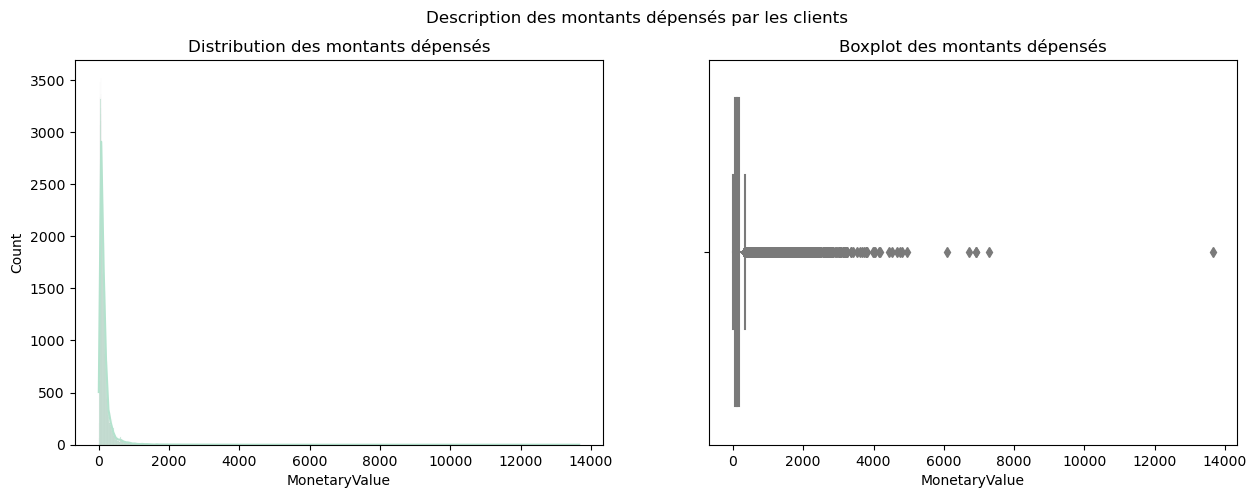

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0],x="MonetaryValue", data=data, kde=True)
axes[0].set_title("Distribution des montants dépensés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=data)
axes[1].set_title("Boxplot des montants dépensés")

plt.show()

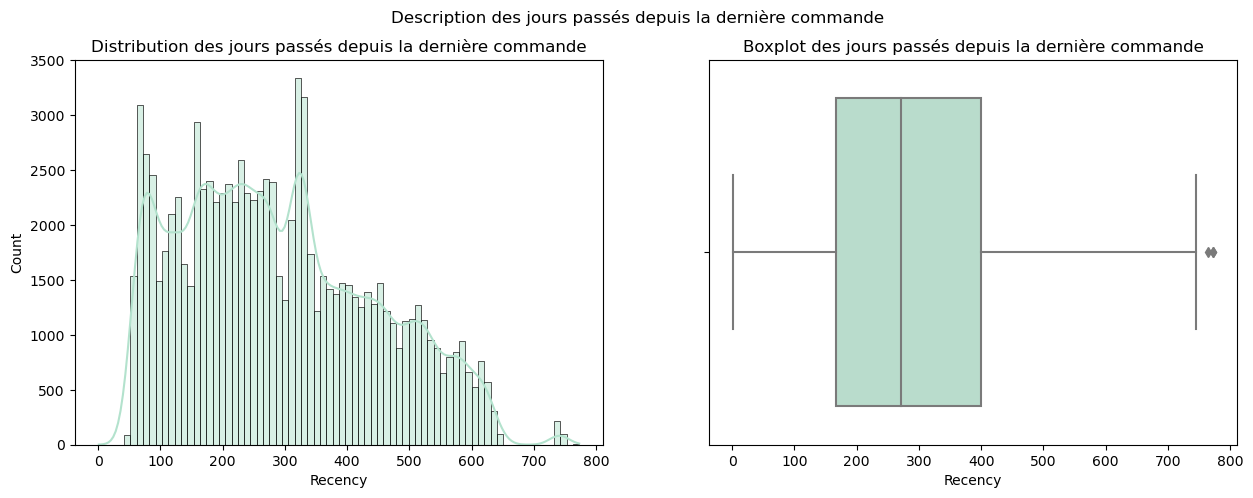

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des jours passés depuis la dernière commande')

sns.histplot(ax=axes[0],x="Recency", data=data, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Recency", data=data)
axes[1].set_title("Boxplot des jours passés depuis la dernière commande")

plt.show()

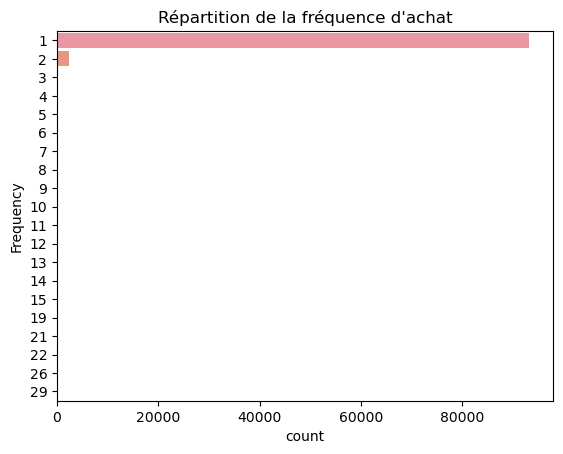

In [22]:
sns.countplot(y="Frequency", data=data)
plt.title("Répartition de la fréquence d'achat")

plt.show()

La fréquence et la récence ne semblent pas être très discriminants. En effet, la plupart des clients réalise un seul achat. De même, il est difficile de savoir s'ils reviennent régulièrement acheter donc la récence est très variable. 

En inspectant le fonctionnement du site, il s'avère que l'on peut commander sans avoir besoin de créer un compte. On ne peut donc pas savoir si une personne commande plusieurs fois et obtenir les informations nécessaires. 

In [23]:
del df_orders_payments
del rfm_custom

In [24]:
gc.collect()

169329

In [25]:
data.set_index("customer_id", inplace=True)

In [26]:
# Enregistrement des données de la segmentation
data.to_csv("datasets/data_segmentation_rfm.csv")

## 2) Ajout de variables supplémentaires

On va créer de nouvelles variables que l'on va ajouter pour pouvoir obtenir une segmentation plus fine.

In [27]:
data.reset_index(inplace=True)

### Calcul des distances entre vendeurs et acheteurs

In [28]:
# Importation des informations vendeurs

df_sellers = pd.read_csv("datasets/olist_sellers_dataset.csv")
df_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [29]:
df_sellers = pd.merge(df_geo, df_sellers,
                        right_on=["seller_zip_code_prefix", "seller_city", "seller_state"], 
                        left_on=["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], how="right")
df_sellers.drop(["geolocation_zip_code_prefix", "geolocation_city", "geolocation_state"], axis=1, inplace=True)
df_sellers = df_sellers[['seller_id', "geolocation_lat", "geolocation_lng"]]
df_sellers.columns = ["seller_id", "seller_latitude", "seller_longitude"]
df_sellers.head()

,seller_id,seller_latitude,seller_longitude
0,3442f8959a84dea7ee197c632cb2df15,-22.898536,-47.063125
1,3442f8959a84dea7ee197c632cb2df15,-22.895499,-47.061944
2,3442f8959a84dea7ee197c632cb2df15,-22.891740,-47.060820
3,3442f8959a84dea7ee197c632cb2df15,-22.895762,-47.066144
4,3442f8959a84dea7ee197c632cb2df15,-22.896154,-47.062431


In [30]:
df_sellers.drop_duplicates(subset="seller_id", inplace=True)

In [31]:
# Importation des informations sur les commandes

df_items = pd.read_csv("datasets/olist_order_items_dataset.csv")
df_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [32]:
df_items = pd.merge(df_orders, df_items, on="order_id", how="left")

In [33]:
df_items = pd.merge(df_items, df_customers, on="customer_id", how="left")

In [34]:
df_items = pd.merge(df_sellers, df_items, on="seller_id", how="left")

In [35]:
df_items.dropna(subset=["customer_city"], inplace=True)

In [36]:
df_items["distance_customer_seller"] = haversine_vectorize(df_items["customer_longitude"], df_items["customer_latitude"], df_items["seller_longitude"], df_items["seller_latitude"])

In [37]:
df_items = df_items[["customer_id", "distance_customer_seller"]]
data = pd.merge(data, df_items, on="customer_id", how="left")

### Informations sur les avis clients

In [38]:
df_reviews = pd.read_csv("datasets/olist_order_reviews_dataset.csv")
df_reviews.head(3)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24


In [39]:
df_reviews.drop(["review_id", "review_creation_date", "review_answer_timestamp"], axis=1, inplace=True)

In [40]:
df_orders = pd.read_csv("datasets/olist_orders_dataset.csv")
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [41]:
df_orders.drop(["order_purchase_timestamp", "order_delivered_carrier_date"], axis=1, inplace=True)
cols_time = ["order_approved_at", "order_delivered_customer_date", "order_estimated_delivery_date"]

for cols in cols_time:
    df_orders[cols] = pd.to_datetime(df_orders[cols], format="%Y-%m-%d", errors="ignore")

In [42]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_approved_at              99281 non-null  datetime64[ns]
 4   order_delivered_customer_date  96476 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 4.6+ MB


### Calcul entre du nombre de jours entre la commande et la réception réel et estimé

In [43]:
df_orders["nb_days_before_delivered"] = df_orders["order_delivered_customer_date"] - df_orders["order_approved_at"]
df_orders["nb_days_before_delivered_estimation"] = df_orders["order_estimated_delivery_date"] - df_orders["order_approved_at"]

cols_var = ["nb_days_before_delivered", "nb_days_before_delivered_estimation"]

for cols in cols_var:
    df_orders[cols] = df_orders[cols].dt.days

df_orders.drop(["order_approved_at", "order_delivered_customer_date", "order_estimated_delivery_date"], axis=1, inplace=True)

In [44]:
df_orders.head()

,order_id,customer_id,order_status,nb_days_before_delivered,nb_days_before_delivered_estimation
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,8.0,15.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,12.0,17.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,9.0,26.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,13.0,26.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2.0,12.0


### Assemblage des différentes variables pour obtenir un dataset unique

In [45]:
df_customers_orders = pd.merge(df_customers, df_orders, on="customer_id", how="left")
df_customers_orders.shape

(96096, 9)

In [46]:
df_customers_orders = pd.merge(df_customers_orders, df_reviews, on="order_id", how="left")
df_customers_orders.shape

(96412, 12)

In [47]:
df_customers_orders.head(3)

,customer_id,customer_unique_id,customer_city,customer_latitude,customer_longitude,order_id,order_status,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,review_comment_title,review_comment_message
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,franca,-20.509897,-47.397866,00e7ee1b050b8499577073aeb2a297a1,delivered,8.0,19.0,4,NaN,NaN
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,sao bernardo do campo,-23.726853,-46.545746,29150127e6685892b6eab3eec79f59c7,delivered,16.0,24.0,5,NaN,NaN
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,sao paulo,-23.527788,-46.660310,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,25.0,23.0,5,NaN,NaN


In [48]:
df_customers_orders.drop(["customer_unique_id", "order_id"], axis=1, inplace=True)

In [49]:
df_customers_orders.shape

(96412, 10)

In [50]:
df_customers_orders = df_customers_orders.groupby("customer_id").mean().reset_index()

In [51]:
data = pd.merge(df_customers_orders, data, on="customer_id", how="left")
data.shape

(109317, 10)

In [52]:
data.head(3)

,customer_id,customer_latitude,customer_longitude,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,Recency,Frequency,MonetaryValue,distance_customer_seller
0,00012a2ce6f8dcda20d059ce98491703,-23.499689,-46.766901,13.0,19.0,1.0,338.0,1.0,114.74,120.729003
1,000161a058600d5901f007fab4c27140,-20.470582,-45.108716,9.0,18.0,4.0,459.0,1.0,67.41,131.914211
2,0001fd6190edaaf884bcaf3d49edf079,-18.716793,-40.397969,5.0,21.0,5.0,597.0,1.0,195.42,550.186581


In [53]:
data = pd.merge(df_customers, data, on="customer_id", how="right")
data.shape

(109317, 14)

In [54]:
data.drop(["customer_unique_id"], axis=1, inplace=True)

In [55]:
data.drop_duplicates(subset="customer_id", inplace=True)

In [56]:
data.drop(["customer_longitude_x", "customer_latitude_x", "customer_longitude_y", "customer_latitude_y"], axis=1, inplace=True)
data.set_index("customer_id", inplace=True)
data.head(3)

,customer_city,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,Recency,Frequency,MonetaryValue,distance_customer_seller
customer_id,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,osasco,13.0,19.0,1.0,338.0,1.0,114.74,120.729003
000161a058600d5901f007fab4c27140,itapecerica,9.0,18.0,4.0,459.0,1.0,67.41,131.914211
0001fd6190edaaf884bcaf3d49edf079,nova venecia,5.0,21.0,5.0,597.0,1.0,195.42,550.186581


In [57]:
data = data.loc[data["nb_days_before_delivered"] > 0]
data = data.loc[data["nb_days_before_delivered_estimation"] > 0]
data = data.loc[data["distance_customer_seller"] > 0]

## 3) Analyse des données clients

In [58]:
# statistiques descriptives
data.describe()

,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,Recency,Frequency,MonetaryValue,distance_customer_seller
count,90205.000000,90205.000000,90205.000000,90205.000000,90205.000000,90205.000000,90205.000000
mean,11.688654,22.894851,4.139113,288.489618,1.044100,156.600685,603.943571
std,9.570794,8.757824,1.296976,152.563602,0.370922,216.720029,599.119124
min,1.000000,1.000000,1.000000,50.000000,1.000000,1.737500,0.174640
25%,6.000000,18.000000,4.000000,165.000000,1.000000,60.000000,189.109677
50%,9.000000,22.000000,5.000000,269.000000,1.000000,102.740000,436.099314
75%,15.000000,28.000000,5.000000,397.000000,1.000000,173.880000,802.679213
max,208.000000,153.000000,5.000000,745.000000,26.000000,13664.080000,8731.462170


### Analyses univariées des variables utilisées pour la segmentation

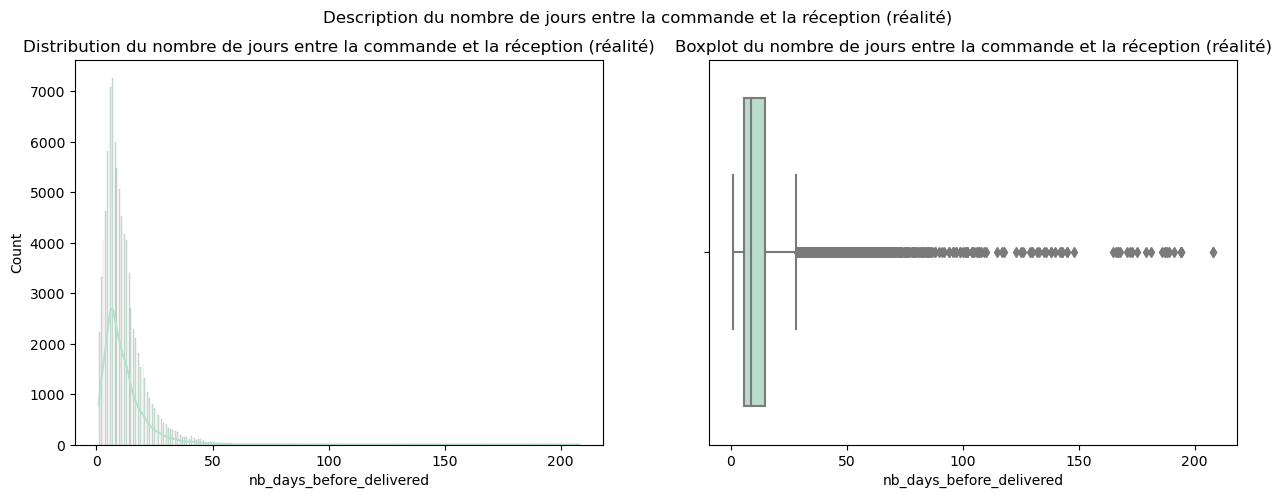

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du nombre de jours entre la commande et la réception (réalité)')

sns.histplot(ax=axes[0],x="nb_days_before_delivered", data=data, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (réalité)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered", data=data)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (réalité)")

plt.show()

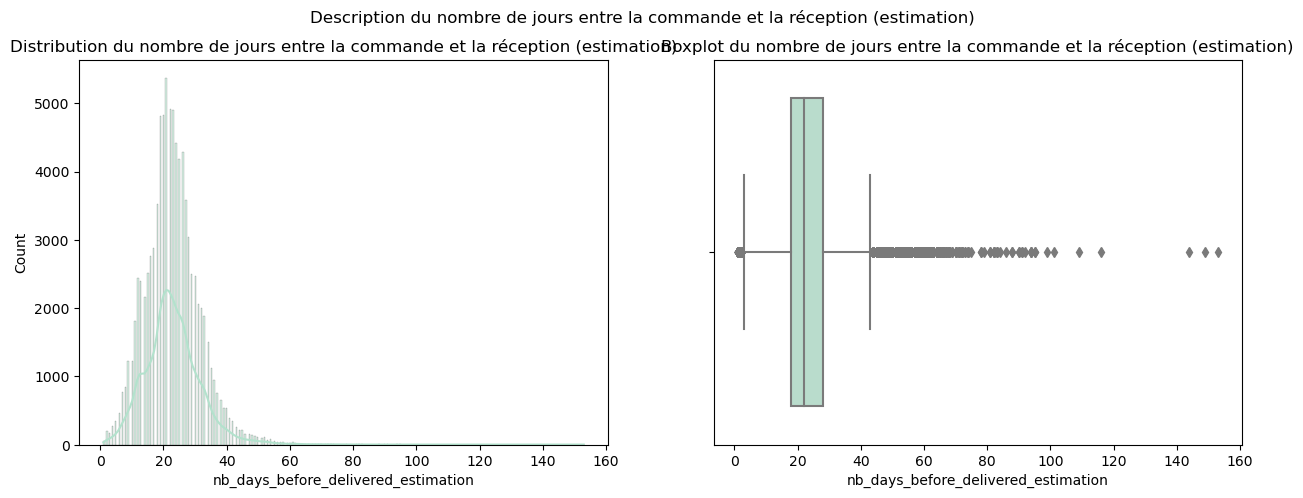

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description du nombre de jours entre la commande et la réception (estimation)')

sns.histplot(ax=axes[0],x="nb_days_before_delivered_estimation", data=data, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (estimation)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered_estimation", data=data)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (estimation)")

plt.show()

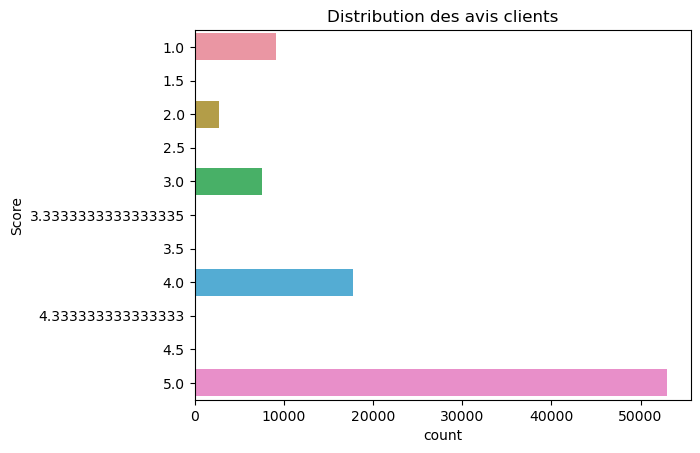

In [61]:
sns.countplot(y="review_score", data=data)
plt.title("Distribution des avis clients")
plt.ylabel("Score")

plt.show()

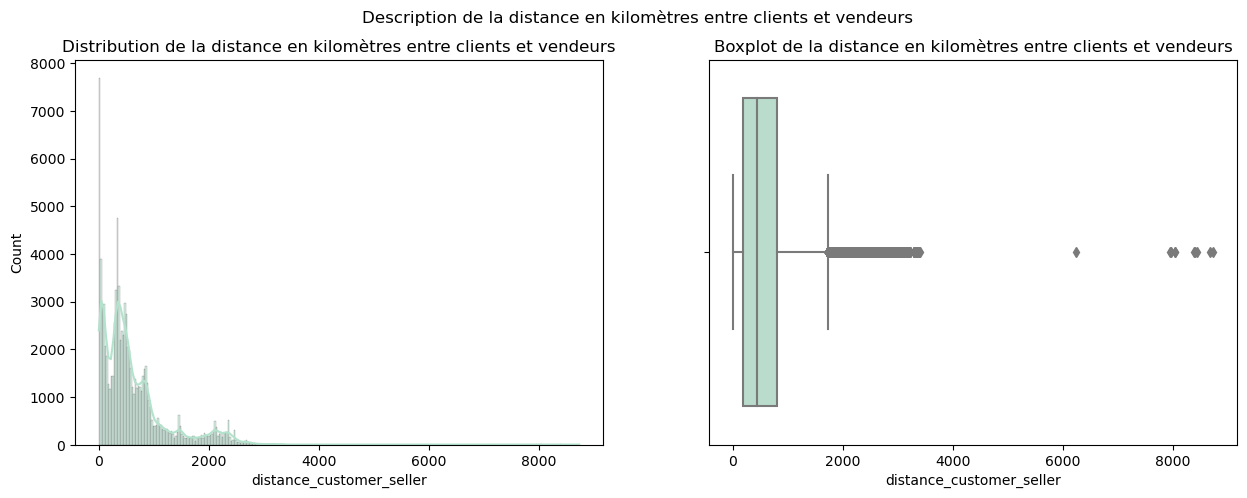

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la distance en kilomètres entre clients et vendeurs')

sns.histplot(ax=axes[0],x="distance_customer_seller", data=data, kde=True)
axes[0].set_title("Distribution de la distance en kilomètres entre clients et vendeurs")

sns.boxplot(ax=axes[1], x="distance_customer_seller", data=data)
axes[1].set_title("Boxplot de la distance en kilomètres entre clients et vendeurs")

plt.show()

In [63]:
data.to_csv("datasets/data_clustering_complete.csv")

**Ressources :**

- Intégration de la plateforme Olist sur le site de Carrefour Brésil: https://www.carrefour.com.br/parceiro/olist